# 1. Sobre o Projeto e Referências

## Indicadores

Com base no dicionário de dados fornecido pela Passos Mágicos, ficou definido que os seguintes indicadores serão utilizados:

### **1. Desempenho em Disciplinas Específicas**  
- **Dados necessários:** `NOTA_PORT`, `NOTA_MAT`, `NOTA_ING`.  
- **Descrição:** Médias de notas em disciplinas específicas, como português, matemática e inglês.

### **2. Frequência Escolar e Engajamento**  
- **Dados necessários:** `FASE`, `TURMA`.  
- **Descrição:** Dados sobre a fase e turma dos alunos, que podem ser utilizados para medir frequência e engajamento ao longo dos anos.

### **3. Indicador de Desempenho Acadêmico (INDE)**  
- **Dados necessários:** `INDE`.  
- **Descrição:** O Índice do Desenvolvimento Educacional (INDE) é uma métrica que combina outros indicadores (IAN, IDA, IEG, IAA, IPS, IPP e IPV) para avaliar o desempenho acadêmico geral dos alunos ao longo dos anos.

### **4. Indicador de Aprendizagem (IDA)**  
- **Dados necessários:** `IDA`.  
- **Descrição:** Média das notas do indicador de aprendizagem, medindo o progresso acadêmico dos alunos.

### **5. Indicador de Engajamento (IEG)**  
- **Dados necessários:** `IEG`.  
- **Descrição:** Média das notas de engajamento dos alunos, mensurando a participação e envolvimento deles nas atividades.

### **6. Indicador Psicossocial (IPS)**  
- **Dados necessários:** `IPS`.  
- **Descrição:** Média das notas psicossociais dos alunos, avaliando seu bem-estar emocional e social.

### **7. Indicador Psicopedagógico (IPP)**  
- **Dados necessários:** `IPP`.  
- **Descrição:** Média das notas psicopedagógicas dos alunos, refletindo o suporte que receberam nesse aspecto.

### **8. Indicador de Autoavaliação (IAA)**  
- **Dados necessários:** `IAA`.  
- **Descrição:** Média das notas de autoavaliação dos alunos, que refletem sua percepção de progresso.

### **9. Indicador de Ponto de Virada (IPV)**  
- **Dados necessários:** `IPV`.  
- **Descrição:** Média das notas que indicam o "ponto de virada" — um momento de mudança significativa no desempenho ou comportamento do aluno.

### **10. Classificação de Desempenho (Pedra)**  
- **Dados necessários:** `PEDRA`.  
- **Descrição:** Classificação dos alunos com base no seu INDE, em níveis como Quartzo, Ágata, Ametista e Topázio.

### **11. Recomendações Psicopedagógicas**  
- **Dados necessários:** `REC_PSICO`.  
- **Descrição:** Recomendações feitas pela equipe psicopedagógica para acompanhamento e suporte ao aluno.

---

## 2.1 Tabela de Indicadores Sugeridos  

| Nome do Campo             | Descrição                                                                                                                                       | Tipo de Dados |
|---------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|---------------|
| `NOTA_PORT`, `NOTA_MAT`, `NOTA_ING` | Médias de notas em disciplinas específicas, como português, matemática e inglês.                                                            | Numérico      |
| `FASE`, `TURMA`           | Dados sobre a fase e turma dos alunos, que podem ser utilizados para medir frequência e engajamento ao longo dos anos.                            | Texto         |
| `INDE`                    | O Índice do Desenvolvimento Educacional (INDE) é uma métrica que combina outros indicadores (IAN, IDA, IEG, IAA, IPS, IPP e IPV) para avaliar o desempenho acadêmico geral dos alunos ao longo dos anos. | Numérico      |
| `IDA`                     | Média das notas do indicador de aprendizagem, medindo o progresso acadêmico dos alunos.                                                          | Numérico      |
| `IEG`                     | Média das notas de engajamento dos alunos, mensurando a participação e envolvimento deles nas atividades.                                        | Numérico      |
| `IPS`                     | Média das notas psicossociais dos alunos, avaliando seu bem-estar emocional e social.                                                            | Numérico      |
| `IPP`                     | Média das notas psicopedagógicas dos alunos, refletindo o suporte que receberam nesse aspecto.                                                   | Numérico      |
| `IAA`                     | Média das notas de autoavaliação dos alunos, que refletem sua percepção de progresso.                                                            | Numérico      |
| `IPV`                     | Média das notas que indicam o "ponto de virada" — um momento de mudança significativa no desempenho ou comportamento do aluno.                    | Numérico      |
| `PEDRA`                   | Classificação dos alunos com base no seu INDE, em níveis como Quartzo, Ágata, Ametista e Topázio.                                                | Texto         |
| `REC_PSICO`               | Recomendações feitas pela equipe psicopedagógica para acompanhamento e suporte ao aluno.                                                          | Texto         |


# 3. Análise e Desenvolvimento do DataFrame

In [ ]:
# importação das bibliotecas que serão utilizadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyspark.sql import SparkSession
import os

In [ ]:
class SparkPostgres:
    def __init__(self, spark, host, port, database, user, password):
        self.spark = spark
        self.url = f"jdbc:postgresql://{host}:{port}/{database}"
        self.properties = {
            "user": user,
            "password": password,
            "driver": "org.postgresql.Driver"
        }
    
    def read(self, table):
        return self.spark.read.jdbc(url=self.url, table=table, properties=self.properties)

    def create_temp_view(self, sql_query, view_name):
        df = self.spark.read.jdbc(url=self.url, table=f"({sql_query}) as tmp", properties=self.properties)
        df.createOrReplaceTempView(view_name)
        return df

In [ ]:
spark = SparkSession.builder.appName("CSV to PostgreSQL").getOrCreate()

host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
database = os.getenv("DB_DATABASE")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
schema = os.getenv("DB_SCHEMA")

spark_postgres = SparkPostgres(spark, host, port, database, user, password)

sql_query = """
    SELECT
        nome,
        instituicao_ensino_aluno,
        idade_aluno,
        anos_pm,
        fase_turma AS fase,
        ponto_virada,
        inde,
        inde_conceito,
        pedra,
        destaque_ieg,
        destaque_ida,
        destaque_ipv,
        iaa,
        ieg,
        ips,
        ida,
        ipp,
        ipv,
        ian,
        ano,
        dt_pst
    FROM
        tb_dados_principais_2020
    UNION ALL
    SELECT
        nome,
        instituicao_ensino_aluno,
        NULL AS idade_aluno, -- Não existe na tabela 2021
        NULL AS anos_pm, -- Não existe na tabela 2021
        fase,
        ponto_virada,
        inde,
        NULL AS inde_conceito, -- Não existe na tabela 2021
        pedra,
        NULL AS destaque_ieg, -- Não existe na tabela 2021
        NULL AS destaque_ida, -- Não existe na tabela 2021
        NULL AS destaque_ipv, -- Não existe na tabela 2021
        iaa,
        ieg,
        ips,
        ida,
        ipp,
        ipv,
        ian,
        ano,
        dt_pst
    FROM
        tb_dados_principais_2021
    UNION ALL
    SELECT
        nome,
        NULL AS instituicao_ensino_aluno, -- Não existe na tabela 2022
        NULL AS idade_aluno, -- Não existe na tabela 2022
        NULL AS anos_pm, -- Não existe na tabela 2022
        fase,
        ponto_virada,
        inde,
        NULL AS inde_conceito, -- Não existe na tabela 2022
        pedra,
        destaque_ieg,
        destaque_ida,
        destaque_ipv,
        iaa,
        ieg,
        ips,
        ida,
        ipp,
        ipv,
        ian,
        ano,
        dt_pst
    FROM
        tb_dados_principais_2022;

    """

df_dados_principais_spark = spark_postgres.create_temp_view(sql_query, "tb_dados_principais")
df_dados_principais = df_dados_principais_spark.toPandas()

In [2]:
df_pm = pd.read_csv('bases_e_documental\pede_passos_dataset_fiap.csv', sep=';')
pd.set_option('display.max_columns', None)
df_pm

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Elitebook\AppData\Local\Temp\ipykernel_4160\277646561.py:1: SyntaxWarning: invalid escape sequence '\p'
  df_pm = pd.read_csv('bases_e_documental\pede_passos_dataset_fiap.csv', sep=';')


,INSTITUICAO_ENSINO_ALUNO_2020,NOME,IDADE_ALUNO_2020,ANOS_PM_2020,FASE_TURMA_2020,PONTO_VIRADA_2020,INDE_2020,INDE_CONCEITO_2020,PEDRA_2020,DESTAQUE_IEG_2020,DESTAQUE_IDA_2020,DESTAQUE_IPV_2020,IAA_2020,IEG_2020,IPS_2020,IDA_2020,IPP_2020,IPV_2020,IAN_2020,FASE_2021,TURMA_2021,INSTITUICAO_ENSINO_ALUNO_2021,SINALIZADOR_INGRESSANTE_2021,PEDRA_2021,INDE_2021,IAA_2021,IEG_2021,IPS_2021,IDA_2021,IPP_2021,REC_EQUIPE_1_2021,REC_EQUIPE_2_2021,REC_EQUIPE_3_2021,REC_EQUIPE_4_2021,PONTO_VIRADA_2021,IPV_2021,IAN_2021,NIVEL_IDEAL_2021,DEFASAGEM_2021,FASE_2022,TURMA_2022,ANO_INGRESSO_2022,BOLSISTA_2022,INDE_2022,CG_2022,CF_2022,CT_2022,PEDRA_2022,DESTAQUE_IEG_2022,DESTAQUE_IDA_2022,DESTAQUE_IPV_2022,IAA_2022,IEG_2022,IPS_2022,IDA_2022,NOTA_PORT_2022,NOTA_MAT_2022,NOTA_ING_2022,QTD_AVAL_2022,IPP_2022,REC_AVA_1_2022,REC_AVA_2_2022,REC_AVA_3_2022,REC_AVA_4_2022,INDICADO_BOLSA_2022,PONTO_VIRADA_2022,IPV_2022,IAN_2022,NIVEL_IDEAL_2022
0,Escola Pública,ALUNO-1,11,2,2H,Não,7.883752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.500020000000001,8.7,7.5,7,5.9375,7.75,10,2.0,G,Rede Decisão,Ingressante,Ametista,7.319,7.5,6.3,6.9,8.8,7.7,Promovido de Fase,Promovido de Fase,Mantido na Fase atual,Não avaliado,Não,8.1,5.0,Nível 3 (7o e 8o ano),-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ALUNO-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,K,2022.0,Não,7.675509,245.0,66.0,6.0,Ametista,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,10.00002,7.581705,7.500,8.816667,8.200000,9.433333,NaN,2.0,5.625000,Mantido na Fase + Bolsa,Mantido na Fase atual,NaN,NaN,Sim,Não,7.916665,5.0,Fase 2 (5º e 6º ano)
2,Escola Pública,ALUNO-3,12,2,3H,Não,7.856389666666666,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.91667,8.9,7.5,5.5,8.125,8.111113333333334,10,3.0,F,Escola Pública,Veterano,Ametista,7.021,7.1,6.9,6.3,5.6,7.3,Promovido de Fase,Promovido de Fase,Mantido na Fase atual,Não avaliado,Não,7.2,10.0,Nível 3 (7o e 8o ano),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Escola Pública,ALUNO-4,10,2,1D,Não,5.076252,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.000020000000001,4.1,6.875,0,7.1875,7.75,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,J,2022.0,Não,7.117065,451.0,69.0,3.0,Ametista,Destaque: A sua boa entrega das lições de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Destaque: A sua boa integração aos Princípios ...,10.00002,8.071429,7.500,5.083333,5.000000,5.166667,NaN,3.0,6.250000,Promovido de Fase,Mantido na Fase atual,Promovido de Fase,NaN,Não,Não,8.055553,5.0,Fase 3 (7º e 8º ano)
4,Escola Pública,ALUNO-5,10,1,2M,Não,8.077085,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integração aos...,7.50002,8,7.5,7.5,8.4375,8.166665,10,2.0,L,Escola Pública,Veterano,Ametista,7.399,7.4,7.5,7.5,5.4,8.5,Promovido de Fase,Mantido na Fase atual,Mantido na Fase atual,Não avaliado,Não,7.4,10.0,Nível 2 (5o e 6o ano),0.0,2.0,L,2019.0,Não,7.232336,415.0,61.0,12.0,Ametista,Destaque: A sua boa entrega das lições de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Destaque: A sua boa integração aos Princípios ...,6.41668,8.557505,7.500,7.083333,6.666667,7.500000,NaN,3.0,6.458333,Mantido na Fase atual,Promovido de Fase,Mantido na Fase

In [3]:
df_alunos = pd.read_csv('bases_e_documental/Base de dados - Passos Mágicos/TbAluno/Merge/merged_data.csv', sep=',')
df_fase = pd.read_csv('bases_e_documental/Base de dados - Passos Mágicos/TbFase/Merge/merged_data.csv', sep=',')
df_historico = pd.read_csv('bases_e_documental\Base de dados - Passos Mágicos\TbHistorico\Merge\merged_data.csv', sep=',')

<>:3: SyntaxWarning: invalid escape sequence '\B'
<>:3: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Elitebook\AppData\Local\Temp\ipykernel_4160\917638746.py:3: SyntaxWarning: invalid escape sequence '\B'
  df_historico = pd.read_csv('bases_e_documental\Base de dados - Passos Mágicos\TbHistorico\Merge\merged_data.csv', sep=',')


In [4]:
# verificar se os três dataframes tem o IdAluno, para que possa ser utilizado como referência no merge
print('IdAluno' in df_alunos.columns)
print('IdAluno' in df_fase.columns)
print('IdAluno' in df_historico.columns)

True
True
True


In [5]:
# junta os 3 dataframes em um só
# Realizar o merge dos DataFrames usando 'IdAluno' como referência
df_merged = df_alunos.merge(df_fase, on='IdAluno', how='left')
df_merged = df_merged.merge(df_historico, on='IdAluno', how='left')

In [6]:
df_merged.head()

,IdAlunoRotinaEducacaoInfantil,IdAluno,IdTurma_x_x,Data,IdProfessorResponsavel,IdUsuarioResponsavel,IdFormularioRotinaEducacaoInfantil,IdAlunoObs,IdTipoOcorrencia,StImpedimento,DataOcorrencia_x,IdUsuarioRegistro,ObservacaoRegistro,DataLiberacao,IdUsuarioLiberacao,ObservacaoLiberacao,DataInclusao,StExibirInternet,IdProfessorRegistro,DataInicialAtestado,DataFinalAtestado,IdResponsavel_x,IdTurma_y_x,IdSituacaoAlunoTurma_x,DataSituacaoAtivo,DataSituacaoInativo,IdFaseNotaInicial_x,OrdemChamada,DataHoraEfetivacaoMatricula,IdUsuarioEfetivacaoMatricula,IdAlunoCursoSuperior,ProblemaAutorizadoMatricula,IdUsuarioAutorizacaoMatricula,StAlunoTurmaNaoPermitePParcial,ES_IdCurriculoOptativa,IdResponsavelFinanceiro,IdTipoResponsavelFinanceiro,IdResponsavelSecundario,IdTipoResponsavelSecundario,IdMotivoInativacao,IdEstabEnsinoInativacao,ComentarioInativacao,Comentario,IdPlanoPagamento_PreMatricula,IdPlanoPagamento_Matricula,SituacaoExcecao_IdSituacaoAlunoTurma,SituacaoExcecao_IdUsuario,SituacaoExcecao_DataRegistro,SituacaoExcecao_Comentario,IdAlunoCurso,IdEventoTipoInscricao,RMOnline_TextoPersonalizado_Confirmacao,StProcessamento_FichaInscricao,StProcessamento_ConfirmacaoReservaOnline,StProcessamento_InscricaoEmTurma,IdAlunoTurma,NomeAluno,NomeAbreviado,IdUnidade,Sexo,EstadoCivil,DataNascimento,IdPai,IdMae,IdResponsavel_y,IdTipoResponsavel,Naturalidade,Nacionalidade,TipoSangue,PlanoSaude,Alergia,Medicamento,IdEstabelecimentoEnsinoAnterior,IdReligiao,AnoConclusao,CorRaca,StDeficienciaCegueira,StDeficienciaBaixaVisao,StDeficienciaSurdez,StDeficienciaAuditiva,StDeficienciaFisica,StDeficienciaSurdoCegueira,StDeficienciaMultipla,StDeficienciaMental,_IdResponsavel_CadastroVinculado,StFalecido,EnsinoMedio_IdEstabelecimentoEnsino,EnsinoMedio_AnoConclusao,StDeficienciaAutismoInfantil,StDeficienciaSindromeAsperger,StDeficienciaSindromeRett,StDeficienciaTrastornoDesintegrativo,StDeficienciaAltasHabilidades,NomeCivil,StAppComunicacao_Sincronizado,IdTipoResponsavelPai,IdTipoResponsavelMae,StRecursoAuxilioLedor,StRecursoAuxilioTranscricao,StRecursoGuiaInterprete,StRecursoTradutorInterpreteDeLibras,StRecursoLeituraLabial,StRecursoMaterialDidaticoProvaBraille,StRecursoProvaAmpliada,StRecursoProvaSuperampliada,StRecursoCdComAudio,StRecursoLinguaPortuguesaSegundaLingua,StRecursoProvaEmVideo,StPermiteUsoImagem,StEstrangeiro,Unnamed: 55,DataOcorrencia_y,IdTurma,IdSituacaoAlunoTurma_y,IdFaseNotaInicial_y,IdUsuario,IdFaseNotaDisciplinaTurma,IdTurma_x_y,IdFaseNota,IdDisciplina_x,ConteudoProgramatico,IdPeriodo,IdSerie,NumeroFase,NomeFase,CabecBoletim,ImprimirBoletimNotaParcial,ImprimirBoletimNPNaoConfirmada,ImprimirBoletimNota,ImprimirBoletimFaltas,StFaseInformada,StCalcularDisciplinaComposta,IdFormulaComposicaoNota,IdFormulaNota,MediaMinimaAprovacao,ValorArredondamentoMedia,IdFormulaAprovacao,IdFormulaFalta,IdFaseNotaAprovacao,IdFaseNotaReprovacao,DataInicioExibicao,NumeroOrdemExibicao,NumeroSemanasLetivas,StCalcularSituacaoGeral,IdFormulaAprovacaoFrequencia,ValorNotaMaxima,DataInicialPeriodoAula,DataFinalPeriodoAula,StCalcDiscCompUtilizaFormulaFN,DataLimiteDigitacaoNota,NumeroDiasLetivos,StDispensarNotaAutomatica,TipoDispensaAutomatica,StConfirmarDispensaAutomatica,SituacaoReprovadoFrequencia,SituacaoAprovado,SituacaoReprovado,StFaseNotaSempreCalcular,TipoInformada,StPermiteProfessorImportarPadraoAvaliacao,StPermiteProfessorInserirEditarAvaliacao,StPermiteProfessorInserirBloco,IdDisciplina_y,IdTurma_y_y,Nota01,Nota02,Nota03,Nota04,Nota05,Nota06,Nota07,Nota08,Nota09,Nota10,IdFormulaComposicao,StNotaConfirmada,NotaFase,Faltas,QuantAulasDadas,_Nota01,StNotaFaseExibirDisp,IdFaseNotaAluno,CodigoSerie_x,AnoConclusao_x,IdDisciplina,StDependencia,Nota_,NotaFinal,CargaHorariaAnual,QuantidadeFaltasAnual,ResultadoFinal_x,IdSerie_x,CargaHorariaAnualExibicao,StCHIgnorarSoma_x,IdHistoricoNotas,NovoEnsinoMedio_GrupoEstruturaCurricular,NovoEnsinoMedio_AreaConhecimento,CargaHorariaAnualHoraMinuto,CargaHorariaAnualHoraMinutoExibicao,StUsaCargaHorariaAnualHoraMinutoTexto,FaltasHoraMin

In [7]:
df_merged.shape

(49089, 217)

In [8]:
df_merged.info(verbose=True, buf=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49089 entries, 0 to 49088
Data columns (total 217 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    IdAlunoRotinaEducacaoInfantil              int64  
 1    IdAluno                                    int64  
 2    IdTurma_x_x                                int64  
 3    Data                                       object 
 4    IdProfessorResponsavel                     float64
 5    IdUsuarioResponsavel                       float64
 6    IdFormularioRotinaEducacaoInfantil         int64  
 7    IdAlunoObs                                 int64  
 8    IdTipoOcorrencia                           int64  
 9    StImpedimento                              bool   
 10   DataOcorrencia_x                           object 
 11   IdUsuarioRegistro                          int64  
 12   ObservacaoRegistro                         object 
 13   DataLiberacao                

In [9]:
# verifica porcentagem de dados nulos por coluna
df_merged.isnull().sum()/df_merged.shape[0]*100

IdAlunoRotinaEducacaoInfantil              0.000000
IdAluno                                    0.000000
IdTurma_x_x                                0.000000
Data                                       0.000000
IdProfessorResponsavel                     0.000000
                                            ...    
FrequenciaTotal                          100.000000
CargaHorariaTotalHoraMinuto              100.000000
CargaHorariaTotalHoraMinutoExibicao      100.000000
StUsaCargaHorariaTotalHoraMinutoTexto     66.642221
TotalFaltasTexto                         100.000000
Length: 217, dtype: float64

In [10]:
# faz o drop da coluna, se 100% dos valores da coluna estiverem nulos
# identifica colunas com 100% de valores nulos
colunas_para_deletar = df_merged.columns[df_merged.isnull().all()]

# converte objeto para uma lista
colunas_para_deletar_lista = colunas_para_deletar.tolist()

# criar um DataFrame para exibir a lista
df_colunas_para_deletar = pd.DataFrame(colunas_para_deletar_lista, columns=['Colunas para Deletar'])

# adiciona uma linha com o total de colunas deletadas
total_deletadas = len(colunas_para_deletar_lista)
df_colunas_para_deletar.loc['Total'] = [f'Total de colunas deletadas: {total_deletadas}']

# exibe o DataFrame resultante
df_colunas_para_deletar

,Colunas para Deletar
0,IdUsuarioResponsavel
1,DataLiberacao
2,IdUsuarioLiberacao
3,ObservacaoLiberacao
4,IdProfessorRegistro
...,...
127,FrequenciaTotal
128,CargaHorariaTotalHoraMinuto
129,CargaHorariaTotalHoraMinutoExibicao
130,TotalFaltasTexto


In [11]:
# deleta as colunas identificadas
df_merged.drop(columns=colunas_para_deletar, inplace=True)

# Exibir o DataFrame atualizado
df_merged.head()

,IdAlunoRotinaEducacaoInfantil,IdAluno,IdTurma_x_x,Data,IdProfessorResponsavel,IdFormularioRotinaEducacaoInfantil,IdAlunoObs,IdTipoOcorrencia,StImpedimento,DataOcorrencia_x,IdUsuarioRegistro,ObservacaoRegistro,DataInclusao,StExibirInternet,IdResponsavel_x,IdTurma_y_x,IdSituacaoAlunoTurma_x,DataSituacaoAtivo,DataSituacaoInativo,OrdemChamada,DataHoraEfetivacaoMatricula,IdUsuarioEfetivacaoMatricula,ProblemaAutorizadoMatricula,IdUsuarioAutorizacaoMatricula,StAlunoTurmaNaoPermitePParcial,IdResponsavelFinanceiro,IdTipoResponsavelFinanceiro,IdMotivoInativacao,IdPlanoPagamento_Matricula,IdAlunoTurma,NomeAluno,IdUnidade,Sexo,EstadoCivil,DataNascimento,IdResponsavel_y,IdTipoResponsavel,CorRaca,StDeficienciaCegueira,StDeficienciaBaixaVisao,StDeficienciaSurdez,StDeficienciaAuditiva,StDeficienciaFisica,StDeficienciaSurdoCegueira,StDeficienciaMultipla,StDeficienciaMental,StFalecido,StDeficienciaAutismoInfantil,StDeficienciaSindromeAsperger,StDeficienciaSindromeRett,StDeficienciaTrastornoDesintegrativo,StDeficienciaAltasHabilidades,StAppComunicacao_Sincronizado,StRecursoAuxilioLedor,StRecursoAuxilioTranscricao,StRecursoGuiaInterprete,StRecursoTradutorInterpreteDeLibras,StRecursoLeituraLabial,StRecursoMaterialDidaticoProvaBraille,StRecursoProvaAmpliada,StRecursoProvaSuperampliada,StRecursoCdComAudio,StRecursoLinguaPortuguesaSegundaLingua,StRecursoProvaEmVideo,StPermiteUsoImagem,StEstrangeiro,DataOcorrencia_y,IdTurma,IdSituacaoAlunoTurma_y,IdUsuario,CodigoSerie_x,AnoConclusao_x,IdDisciplina,StDependencia,NotaFinal,QuantidadeFaltasAnual,ResultadoFinal_x,StCHIgnorarSoma_x,IdHistoricoNotas,StUsaCargaHorariaAnualHoraMinutoTexto,CodigoSerie_y,AnoConclusao_y,ResultadoFinal_y,IdEstabelecimentoEnsino,StCHIgnorarSoma_y,StUsaCargaHorariaTotalHoraMinutoTexto
0,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-08-20 17:44:09.803000,231,1.0,15,n16,2021.0,17.0,0.0,,0.0,A,False,2.0,False,n16,2021.0,A,2083.0,False,False
1,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-09-22 12:25:38.363000,142,1.0,14,n16,2021.0,17.0,0.0,,0.0,A,False,2.0,False,n16,2021.0,A,2083.0,False,False
2,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-12-28 15:14:53.953000,142,9.0,15,n16,2021.0,17.0,0.0,,0.0,A,False,2.0,False,n16,2021.0,A,2083.0,False,False
3,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-12-28 15:21

In [12]:
# mostra dataframe inteiro, sem truncar informações
pd.set_option('display.max_columns', None)
df_merged.head()

,IdAlunoRotinaEducacaoInfantil,IdAluno,IdTurma_x_x,Data,IdProfessorResponsavel,IdFormularioRotinaEducacaoInfantil,IdAlunoObs,IdTipoOcorrencia,StImpedimento,DataOcorrencia_x,IdUsuarioRegistro,ObservacaoRegistro,DataInclusao,StExibirInternet,IdResponsavel_x,IdTurma_y_x,IdSituacaoAlunoTurma_x,DataSituacaoAtivo,DataSituacaoInativo,OrdemChamada,DataHoraEfetivacaoMatricula,IdUsuarioEfetivacaoMatricula,ProblemaAutorizadoMatricula,IdUsuarioAutorizacaoMatricula,StAlunoTurmaNaoPermitePParcial,IdResponsavelFinanceiro,IdTipoResponsavelFinanceiro,IdMotivoInativacao,IdPlanoPagamento_Matricula,IdAlunoTurma,NomeAluno,IdUnidade,Sexo,EstadoCivil,DataNascimento,IdResponsavel_y,IdTipoResponsavel,CorRaca,StDeficienciaCegueira,StDeficienciaBaixaVisao,StDeficienciaSurdez,StDeficienciaAuditiva,StDeficienciaFisica,StDeficienciaSurdoCegueira,StDeficienciaMultipla,StDeficienciaMental,StFalecido,StDeficienciaAutismoInfantil,StDeficienciaSindromeAsperger,StDeficienciaSindromeRett,StDeficienciaTrastornoDesintegrativo,StDeficienciaAltasHabilidades,StAppComunicacao_Sincronizado,StRecursoAuxilioLedor,StRecursoAuxilioTranscricao,StRecursoGuiaInterprete,StRecursoTradutorInterpreteDeLibras,StRecursoLeituraLabial,StRecursoMaterialDidaticoProvaBraille,StRecursoProvaAmpliada,StRecursoProvaSuperampliada,StRecursoCdComAudio,StRecursoLinguaPortuguesaSegundaLingua,StRecursoProvaEmVideo,StPermiteUsoImagem,StEstrangeiro,DataOcorrencia_y,IdTurma,IdSituacaoAlunoTurma_y,IdUsuario,CodigoSerie_x,AnoConclusao_x,IdDisciplina,StDependencia,NotaFinal,QuantidadeFaltasAnual,ResultadoFinal_x,StCHIgnorarSoma_x,IdHistoricoNotas,StUsaCargaHorariaAnualHoraMinutoTexto,CodigoSerie_y,AnoConclusao_y,ResultadoFinal_y,IdEstabelecimentoEnsino,StCHIgnorarSoma_y,StUsaCargaHorariaTotalHoraMinutoTexto
0,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-08-20 17:44:09.803000,231,1.0,15,n16,2021.0,17.0,0.0,,0.0,A,False,2.0,False,n16,2021.0,A,2083.0,False,False
1,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-09-22 12:25:38.363000,142,1.0,14,n16,2021.0,17.0,0.0,,0.0,A,False,2.0,False,n16,2021.0,A,2083.0,False,False
2,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-12-28 15:14:53.953000,142,9.0,15,n16,2021.0,17.0,0.0,,0.0,A,False,2.0,False,n16,2021.0,A,2083.0,False,False
3,16139,727,231,2021-08-24 00:00:00,11.0,1,9789,21,False,2023-05-08 00:00:00,298,Seguem em atendimento psicologico,2023-05-15 17:09:00,False,615,231,9,2021-01-01 00:00:00,2021-12-31 00:00:00,1,2021-08-20 00:00:00,NaN,NaN,NaN,False,615.0,4.0,NaN,8.0,734,Aluno 724,1.0,M,5.0,2001-07-23 03:00:00,615.0,4,B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-12-28 15:21

In [13]:
# altera informações da coluna IdTipoResponsável para facilitar a visualização
df_merged['IdTipoResponsavel'] = df_merged['IdTipoResponsavel'].replace({1 : 'Pai', 2 : 'Mãe', 3 : 'O Próprio', 4 : 'Outros', 5 : 'Tia', 6 : 'Padrasto', 7 : 'Madrasta', 8 : 'Avó', 9 : 'Avô', 10 : 'Tio', 11 : 'Não definido', 12 : 'Outros Responsáveis', 13 : 'Mãe', 14 : 'Irmão', 15 : 'IRM'})

In [14]:
# contagem de valores de uma coluna
df_merged['IdTipoResponsavel'].value_counts()

IdTipoResponsavel
Outros       48585
O Próprio      504
Name: count, dtype: int64

In [15]:
# altera informações da coluna Sexo para facilitar a visualização
df_merged['Sexo'] = df_merged['Sexo'].replace({'F': 'Feminino', 'M': 'Masculino'})

In [16]:
# altera informações da coluna CoraRaca para facilitar a visualização
df_merged['CorRaca'] = df_merged['CorRaca'].replace({'B': 'Branca', 'P': 'Preta', 'R': 'Não especificado'})

In [17]:
# verifica porcentagem de dados nulos por coluna
df_merged.isnull().sum()/df_merged.shape[0]*100

IdAlunoRotinaEducacaoInfantil             0.000000
IdAluno                                   0.000000
IdTurma_x_x                               0.000000
Data                                      0.000000
IdProfessorResponsavel                    0.000000
                                           ...    
AnoConclusao_y                           66.642221
ResultadoFinal_y                         66.642221
IdEstabelecimentoEnsino                  66.642221
StCHIgnorarSoma_y                        66.642221
StUsaCargaHorariaTotalHoraMinutoTexto    66.642221
Length: 86, dtype: float64

In [18]:
# drop em colunas que possuem menos de 100% do total de valores nulos - analisado caso - a - caso antes da deleção
df_merged.drop(columns=['IdUsuarioEfetivacaoMatricula', 'ProblemaAutorizadoMatricula', 'IdUsuarioAutorizacaoMatricula', 'IdMotivoInativacao', 'IdDisciplina', 'StDependencia', 'NotaFinal', 'IdHistoricoNotas', 'StUsaCargaHorariaAnualHoraMinutoTexto', 'IdEstabelecimentoEnsino', 'StUsaCargaHorariaTotalHoraMinutoTexto', 'StCHIgnorarSoma_x', 'StCHIgnorarSoma_y'], inplace=True)  

In [19]:
df_merged.shape

(49089, 73)

In [20]:
# transforma colunas object do dataframe em datetime
columns = ['Data', 'DataOcorrencia_x', 'DataInclusao', 'DataSituacaoAtivo', 'DataSituacaoInativo', 'DataHoraEfetivacaoMatricula', 'DataNascimento', 'DataOcorrencia_y']
df_merged[columns] = df_merged[columns].apply(pd.to_datetime, errors='coerce')

In [21]:
# Certifica que as colunas são do tipo datetime
df_merged['DataNascimento'] = pd.to_datetime(df_merged['DataNascimento'], errors='coerce')
df_merged['DataInclusao'] = pd.to_datetime(df_merged['DataInclusao'], errors='coerce')
df_merged['DataHoraEfetivacaoMatricula'] = pd.to_datetime(df_merged['DataHoraEfetivacaoMatricula'], errors='coerce')
df_merged['DataOcorrencia_y'] = pd.to_datetime(df_merged['DataOcorrencia_y'], errors='coerce')

In [22]:
# transforma colunas datetime em data, sem horário
df_merged[['DataNascimento', 'DataInclusao', 'DataHoraEfetivacaoMatricula', 'DataOcorrencia_y']] = df_merged[['DataNascimento', 'DataInclusao', 'DataHoraEfetivacaoMatricula', 'DataOcorrencia_y']].apply(lambda x: x.dt.date)

In [23]:
df_merged.info(verbose=True, buf=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49089 entries, 0 to 49088
Data columns (total 73 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   IdAlunoRotinaEducacaoInfantil           49089 non-null  int64         
 1   IdAluno                                 49089 non-null  int64         
 2   IdTurma_x_x                             49089 non-null  int64         
 3   Data                                    49089 non-null  datetime64[ns]
 4   IdProfessorResponsavel                  49089 non-null  float64       
 5   IdFormularioRotinaEducacaoInfantil      49089 non-null  int64         
 6   IdAlunoObs                              49089 non-null  int64         
 7   IdTipoOcorrencia                        49089 non-null  int64         
 8   StImpedimento                           49089 non-null  bool          
 9   DataOcorrencia_x                        49089 non-

In [24]:
df_merged.head()

,IdAlunoRotinaEducacaoInfantil,IdAluno,IdTurma_x_x,Data,IdProfessorResponsavel,IdFormularioRotinaEducacaoInfantil,IdAlunoObs,IdTipoOcorrencia,StImpedimento,DataOcorrencia_x,IdUsuarioRegistro,ObservacaoRegistro,DataInclusao,StExibirInternet,IdResponsavel_x,IdTurma_y_x,IdSituacaoAlunoTurma_x,DataSituacaoAtivo,DataSituacaoInativo,OrdemChamada,DataHoraEfetivacaoMatricula,StAlunoTurmaNaoPermitePParcial,IdResponsavelFinanceiro,IdTipoResponsavelFinanceiro,IdPlanoPagamento_Matricula,IdAlunoTurma,NomeAluno,IdUnidade,Sexo,EstadoCivil,DataNascimento,IdResponsavel_y,IdTipoResponsavel,CorRaca,StDeficienciaCegueira,StDeficienciaBaixaVisao,StDeficienciaSurdez,StDeficienciaAuditiva,StDeficienciaFisica,StDeficienciaSurdoCegueira,StDeficienciaMultipla,StDeficienciaMental,StFalecido,StDeficienciaAutismoInfantil,StDeficienciaSindromeAsperger,StDeficienciaSindromeRett,StDeficienciaTrastornoDesintegrativo,StDeficienciaAltasHabilidades,StAppComunicacao_Sincronizado,StRecursoAuxilioLedor,StRecursoAuxilioTranscricao,StRecursoGuiaInterprete,StRecursoTradutorInterpreteDeLibras,StRecursoLeituraLabial,StRecursoMaterialDidaticoProvaBraille,StRecursoProvaAmpliada,StRecursoProvaSuperampliada,StRecursoCdComAudio,StRecursoLinguaPortuguesaSegundaLingua,StRecursoProvaEmVideo,StPermiteUsoImagem,StEstrangeiro,DataOcorrencia_y,IdTurma,IdSituacaoAlunoTurma_y,IdUsuario,CodigoSerie_x,AnoConclusao_x,QuantidadeFaltasAnual,ResultadoFinal_x,CodigoSerie_y,AnoConclusao_y,ResultadoFinal_y
0,16139,727,231,2021-08-24,11.0,1,9789,21,False,2023-05-08,298,Seguem em atendimento psicologico,2023-05-15,False,615,231,9,2021-01-01,2021-12-31,1,2021-08-20,False,615.0,4.0,8.0,734,Aluno 724,1.0,Masculino,5.0,2001-07-23,615.0,Outros,Branca,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-08-20,231,1.0,15,n16,2021.0,0.0,A,n16,2021.0,A
1,16139,727,231,2021-08-24,11.0,1,9789,21,False,2023-05-08,298,Seguem em atendimento psicologico,2023-05-15,False,615,231,9,2021-01-01,2021-12-31,1,2021-08-20,False,615.0,4.0,8.0,734,Aluno 724,1.0,Masculino,5.0,2001-07-23,615.0,Outros,Branca,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-09-22,142,1.0,14,n16,2021.0,0.0,A,n16,2021.0,A
2,16139,727,231,2021-08-24,11.0,1,9789,21,False,2023-05-08,298,Seguem em atendimento psicologico,2023-05-15,False,615,231,9,2021-01-01,2021-12-31,1,2021-08-20,False,615.0,4.0,8.0,734,Aluno 724,1.0,Masculino,5.0,2001-07-23,615.0,Outros,Branca,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-12-28,142,9.0,15,n16,2021.0,0.0,A,n16,2021.0,A
3,16139,727,231,2021-08-24,11.0,1,9789,21,False,2023-05-08,298,Seguem em atendimento psicologico,2023-05-15,False,615,231,9,2021-01-01,2021-12-31,1,2021-08-20,False,615.0,4.0,8.0,734,Aluno 724,1.0,Masculino,5.0,2001-07-23,615.0,Outros,Branca,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021-12-28,231,9.0,15,n16,2021.0,0.0,A,n16,2021.0,A
4,16139,727,231,2021-08-24,11.0,1,9789,21,False,2023-05-08,298,Seguem em atendimento psicologico,2023-05-15,False,615,231,9,2021-01-01,2021-12-31,1,2021-08-20,False,615.0,4.0,8.0,734,Aluno 724,1.0,Masculino,5.0,2001-07-23,615.0,Outros,Branca,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2022-02-09,198,1.0,16,n16,2021.0,0.0,A,n16,2021.0,A


In [25]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
IdAlunoRotinaEducacaoInfantil,49089.0,64766.091833,3923.0,21034.0,74733.0,98479.0,118065.0,38270.366572
IdAluno,49089.0,855.12186,727.0,727.0,773.0,1147.0,1310.0,178.101829
IdTurma_x_x,49089.0,305.032512,231.0,231.0,273.0,453.0,505.0,89.656826
Data,49089,2022-05-14 09:54:33.067285760,2021-08-24 00:00:00,2021-10-20 00:00:00,2022-08-04 00:00:00,2022-09-27 00:00:00,2023-03-21 00:00:00,NaN
IdProfessorResponsavel,49089.0,10.755465,3.0,8.0,11.0,11.0,21.0,4.557007
IdFormularioRotinaEducacaoInfantil,49089.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
IdAlunoObs,49089.0,9662.59054,138.0,5766.0,10224.0,11986.0,22845.0,4567.253259
IdTipoOcorrencia,49089.0,22.275113,11.0,20.0,21.0,26.0,35.0,6.679764
DataOcorrencia_x,49089,2023-03-11 20:59:39.099187200,2021-08-05 00:00:00,2022-11-09 00:00:00,2023-05-11 00:00:00,2023-06-01 00:00:00,2024-04-12 00:00:00,NaN
IdUsuarioRegistro,49089.0,306.585182,298.0,298.0,298.0,313.0,342.0,15.052832


In [26]:

# contagem de valores nulos
null_values = df_merged.isnull().sum()

# calores únicos em cada coluna
unique_values = df_merged.nunique()

# análise descritiva básica
desc_stats = df_merged.describe(include='all')

# exibir as análises descritivas, contagem de valores nulos e valores únicos
null_values, unique_values, desc_stats

(IdAlunoRotinaEducacaoInfantil        0
 IdAluno                              0
 IdTurma_x_x                          0
 Data                                 0
 IdProfessorResponsavel               0
                                  ...  
 QuantidadeFaltasAnual            32714
 ResultadoFinal_x                 32714
 CodigoSerie_y                    32714
 AnoConclusao_y                   32714
 ResultadoFinal_y                 32714
 Length: 73, dtype: int64,
 IdAlunoRotinaEducacaoInfantil    179
 IdAluno                            8
 IdTurma_x_x                        5
 Data                              66
 IdProfessorResponsavel             7
                                 ... 
 QuantidadeFaltasAnual              1
 ResultadoFinal_x                   1
 CodigoSerie_y                      1
 AnoConclusao_y                     1
 ResultadoFinal_y                   1
 Length: 73, dtype: int64,
         IdAlunoRotinaEducacaoInfantil       IdAluno   IdTurma_x_x  \
 count            

## 3.1 Contagem de Valores Nulos

A contagem de valores nulos nas principais colunas identificou um número significativo de valores faltantes em várias colunas importantes, incluindo:

- `QuantidadeFaltasAnual`, `ResultadoFinal_x`, `CodigoSerie_y`, e `AnoConclusao_y`: Todas apresentam cerca de 32.714 valores nulos em 49.089 registros.

- Isso representa quase 67% de valores nulos nessas colunas, o que é um ponto crítico que pode comprometer as análises de desempenho, engajamento e progresso acadêmico.

**Implicações:**

- `QuantidadeFaltasAnual`, `ResultadoFinal_x`, `CodigoSerie_y`, e `AnoConclusao_y`: Todas apresentam cerca de 32.714 valores nulos em 49.089 registros.

- Isso representa quase 67% de valores nulos nessas colunas, o que é um ponto crítico que pode comprometer as análises de desempenho, engajamento e progresso acadêmico.

## 3.2 Valores Únicos

Algumas colunas possuem valores extremamente repetitivos ou até únicos:

- **`ResultadoFinal_x`, `CodigoSerie_y`, e `AnoConclusao_y`**: Cada um desses campos tem apenas um valor único em todos os registros.

- Para `ResultadoFinal_x`, todos os registros disponíveis estão marcados como "Aprovado". Isso levanta dúvidas sobre a integridade ou completude dos dados.

**Implicações:**

- **Dados de resultados limitados:** Com um único valor "Aprovado" para todos os registros, fica impossível distinguir entre alunos que passaram ou falharam. Isso sugere que há uma falta de dados sobre alunos que não tiveram bom desempenho.

- **Falta de variabilidade em séries e anos de conclusão:** Isso impede uma análise longitudinal, ou seja, uma análise que verifique melhorias ou mudanças ao longo do tempo. Se todos os alunos estão no mesmo ano ou série, é difícil entender se há um progresso significativo.

## 3.3 Análise Descritiva

A função `describe()` fornece algumas estatísticas básicas sobre a distribuição dos dados:

- **`IdAlunoRotinaEducacaoInfantil` e `IdAluno`**: O número de alunos é relativamente pequeno em comparação com o total de registros (49.089), o que indica que os mesmos alunos aparecem várias vezes.

- **Faltas Anuais**: A média registrada é zero, o que reforça a ausência de dados de faltas, sendo uma área de grande preocupação.

**Implicações:**

- **Dados repetidos por aluno:** O fato de que um pequeno número de alunos aparece repetidamente sugere que estamos lidando com dados de múltiplas observações por aluno (provavelmente ao longo do tempo ou em diferentes turmas), o que seria normal em um acompanhamento contínuo. No entanto, seria necessário limpar e organizar os dados para focar nas métricas mais significativas por aluno.

- **Faltas não registradas:** Com uma média de faltas igual a zero, conclui-se que os dados de frequência são ineficazes para análises que dependem de engajamento ou presença dos alunos.

## 3.4 Pontos de Atenção

- **Preenchimento de valores nulos:** A base de dados deve ser revisada para preencher os valores nulos ou lidar com eles de forma apropriada. Dependendo da disponibilidade de dados, pode ser necessário estimar alguns desses valores ou remover registros incompletos.

- **Registro de faltas e resultados finais:** Há uma necessidade crítica de melhorar o registro de informações sobre faltas e desempenho acadêmico. Sem essas informações, será impossível medir adequadamente o progresso dos alunos e o impacto da ONG.

- **Variabilidade dos dados:** A falta de variabilidade em dados importantes, como os resultados finais e séries, limita qualquer análise significativa. Será importante diversificar os dados coletados, especialmente em termos de resultados de alunos.

## 3.5 Recomendações para Melhorar a Análise

- **Revisar a coleta de dados**: É necessário garantir que todos os alunos tenham seus resultados finais e faltas registrados corretamente.

- **Tratar os dados ausentes**: Colunas com muitos valores nulos precisam ser preenchidas (se possível) ou desconsideradas caso estejam comprometendo as análises.

- **Analisar alunos individualmente**: Dado que existem múltiplos registros por aluno, seria útil realizar uma análise focada em cada aluno individualmente, para evitar a distorção causada por múltiplos registros que, talvez, não acrescentem valor.

## 3.6 Representação Visual dos Problemas de base

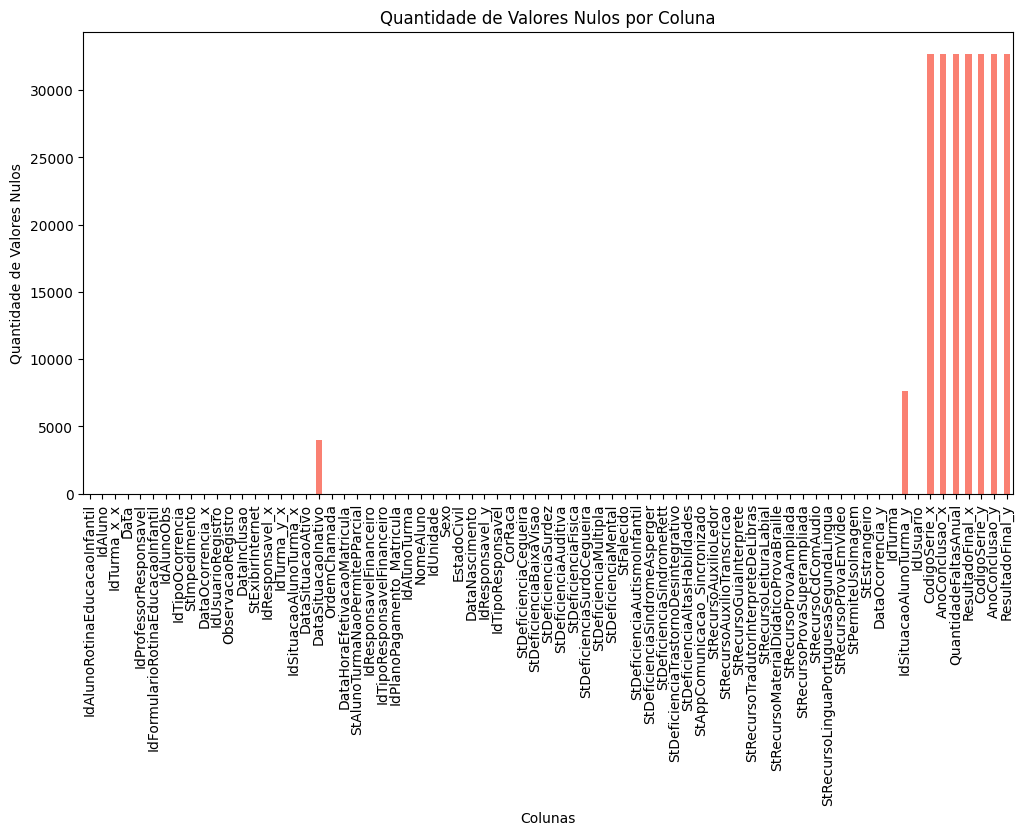

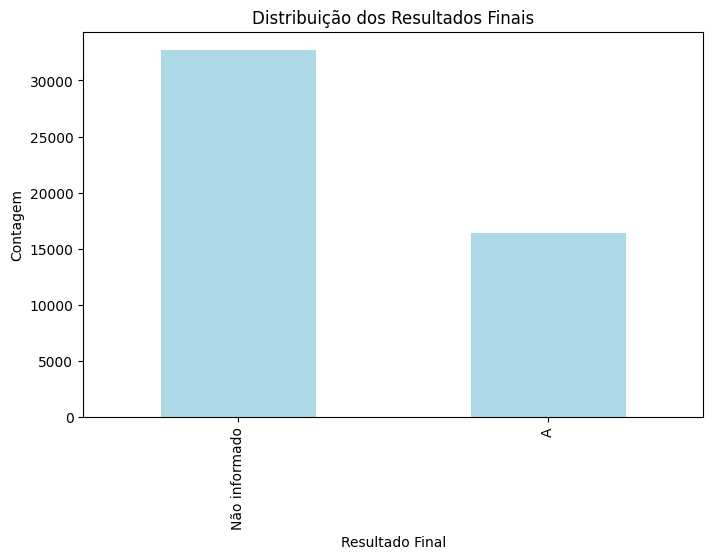

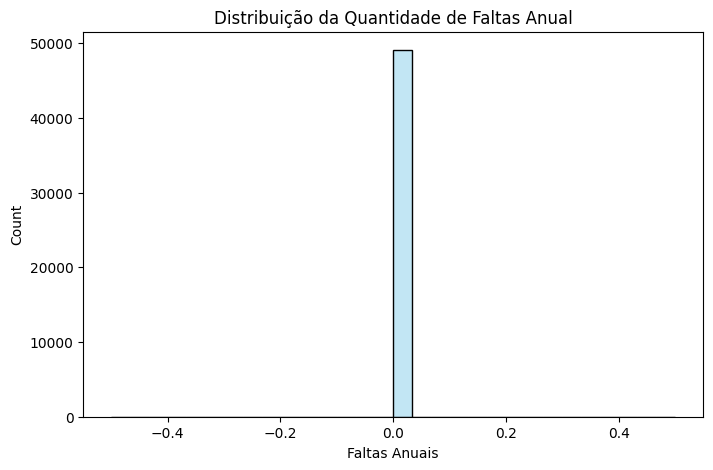

In [27]:
# Gráfico 1: Quantidade de valores nulos por coluna
plt.figure(figsize=(12, 6))
null_values.plot(kind='bar', color='salmon')
plt.title('Quantidade de Valores Nulos por Coluna')
plt.ylabel('Quantidade de Valores Nulos')
plt.xlabel('Colunas')
plt.xticks(rotation=90)
plt.show()

# Gráfico 2: Distribuição dos Resultados Finais (ResultadoFinal_x)
plt.figure(figsize=(8, 5))
df_merged['ResultadoFinal_x'].fillna('Não informado').value_counts().plot(kind='bar', color='lightblue')
plt.title('Distribuição dos Resultados Finais')
plt.ylabel('Contagem')
plt.xlabel('Resultado Final')
plt.show()

# Gráfico 3: Histograma da Distribuição de Faltas Anuais
plt.figure(figsize=(8, 5))
sns.histplot(df_merged['QuantidadeFaltasAnual'].fillna(0), bins=30, kde=True, color='skyblue')
plt.title('Distribuição da Quantidade de Faltas Anual')
plt.xlabel('Faltas Anuais')
plt.show()

- **Quantidade de Valores Nulos por Coluna**: Número de valores ausentes em cada coluna, com destaque para colunas críticas como `QuantidadeFaltasAnual`, `ResultadoFinal_x`, e `AnoConclusao_y`, que apresentam muitos valores nulos.

- `Distribuição dos Resultados Finais`: A maioria dos registros está classificada como "Aprovado", com uma grande parte de dados ausentes (preenchidos como "Não informado"), indicando um problema de variabilidade nos dados de desempenho.

- `Distribuição da Quantidade de Faltas Anual`: Embora muitos dados estejam faltando, o histograma mostra que a maioria dos alunos não tem faltas registradas, o que levanta a questão sobre a completude dos dados de presença.

## 3.7 Conclusão sobre a Viabilidade da Base de Dados

Os dados parecem incompletos em várias áreas críticas, como o desempenho acadêmico e a presença dos alunos. Além disso, a maioria dos alunos está marcada como "Aprovado", o que pode refletir uma simplificação excessiva ou a ausência de registros de reprovação, distorcendo os resultados.

Se os ajustes propostos forem implementados com sucesso (preenchimento de nulos, maior variabilidade nos resultados e dados completos), a base pode ser viável, mas limitada. Certas análises (como de presença e engajamento) ainda seriam prejudicadas sem dados adequados.

Para a base compartilhada, a análise ser focada nos dados que estão mais completos, como análises específicas de desempenho com os alunos que possuem dados completos.

## 3.8 Recomendações Finais
Focar em Subconjuntos de Dados Completos: Muitas das análises viáveis dependem de filtrar o dataset para trabalhar apenas com os registros que possuem dados completos. Embora isso reduza o tamanho da amostra, ainda é possível gerar insights importantes.

Documentar Limitações: Ao realizar qualquer uma dessas análises, é crucial documentar as limitações impostas pelos dados ausentes. Isso garante que as conclusões sejam interpretadas com cautela e que os resultados não sejam extrapolados indevidamente.

Melhorar a Coleta de Dados Futuramente: Embora possamos realizar análises viáveis com o que temos, é fundamental melhorar a coleta de dados no futuro, especialmente em áreas críticas como desempenho acadêmico, frequência e registros socioeconômicos.

## 3.9 Tratamento da Base Municipios

In [28]:
df_municipio = pd.read_csv('bases_e_documental/Base de dados - Passos Mágicos/Outras tabelas/TbMunicipio.csv', sep=',')
df_municipio.head()

,IdMunicipio,NomeMunicipio,UF,CodigoIBGE
0,1,ABADIA DE GOIÁS,GO,5200050
1,2,ABADIA DOS DOURADOS,MG,3100104
2,3,ABADIÂNIA,GO,5200100
3,4,ABAETÉ,MG,3100203
4,5,ABAETETUBA,PA,1500107


In [29]:
df_municipio.shape

(5563, 4)

In [30]:
df_municipio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563 entries, 0 to 5562
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IdMunicipio    5563 non-null   int64 
 1   NomeMunicipio  5563 non-null   object
 2   UF             5563 non-null   object
 3   CodigoIBGE     5563 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.0+ KB


In [31]:
df_municipio.isnull().sum()

IdMunicipio      0
NomeMunicipio    0
UF               0
CodigoIBGE       0
dtype: int64

In [32]:
# exporta a base de municipios para csv
# df_municipio.to_csv('bases_e_documental/df_municipio.csv', index=False)

# 4. Gráficos de Apoio para o Relatório Final

## 4.1 Análise de Desempenho dos Alunos com Dados Completos

In [33]:
# Filtrar os dados para incluir apenas os registros com dados completos para ResultadoFinal_x, AnoConclusao_y, e QuantidadeFaltasAnual
df_filtered = df_merged.dropna(subset=['ResultadoFinal_x', 'AnoConclusao_y', 'QuantidadeFaltasAnual'])

# Contar o número de alunos aprovados (ResultadoFinal_x = 'Aprovado') e reprovados
aprovados = df_filtered['ResultadoFinal_x'].value_counts()

# Calcular a taxa de aprovação
total_alunos = len(df_filtered)
taxa_aprovacao = aprovados.get('A', 0) / total_alunos if total_alunos > 0 else 0

# Exibir a taxa de aprovação e o total de alunos
print(f"Taxa de Aprovação: {taxa_aprovacao * 100}%")
print(f"Total de Alunos com Dados Completos: {total_alunos}")

Taxa de Aprovação: 100.0%
Total de Alunos com Dados Completos: 16375


C:\Users\Elitebook\AppData\Local\Temp\ipykernel_4160\2376461573.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ResultadoFinal_x', data=df_filtered, palette='Blues')
c:\Users\Elitebook\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


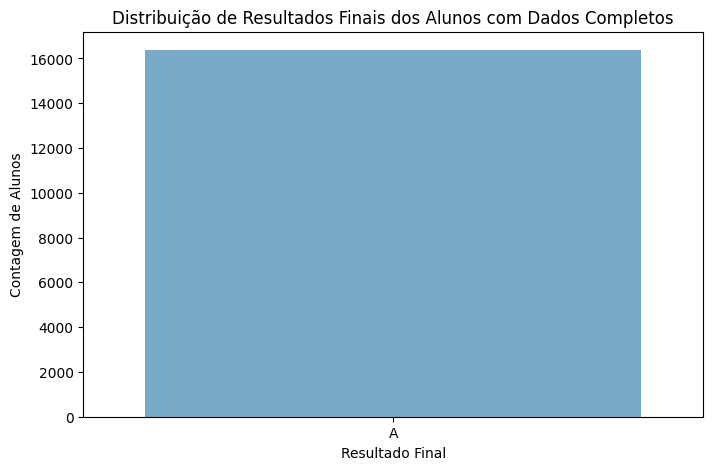

In [34]:
# Gerar gráfico de barras para visualização do desempenho
plt.figure(figsize=(8, 5))
sns.countplot(x='ResultadoFinal_x', data=df_filtered, palette='Blues')
plt.title('Distribuição de Resultados Finais dos Alunos com Dados Completos')
plt.xlabel('Resultado Final')
plt.ylabel('Contagem de Alunos')
plt.show()

## 4.2 Correlação entre Variáveis Socioeconômicas e Desempenho

In [35]:
# Filtrar os dados para incluir registros com dados completos para ResultadoFinal_x e IdResponsavelFinanceiro
df_filtered_socio = df_filtered.dropna(subset=['IdResponsavelFinanceiro'])

# Converter a coluna de resultado final para uma variável binária (Aprovado = 1, Reprovado = 0)
df_filtered_socio['Aprovado'] = df_filtered_socio['ResultadoFinal_x'].apply(lambda x: 1 if x == 'A' else 0)

# Calcular a correlação entre IdResponsavelFinanceiro e o resultado acadêmico (Aprovado)
correlacao_socio_desempenho = df_filtered_socio['IdResponsavelFinanceiro'].corr(df_filtered_socio['Aprovado'])

# Exibir a correlação calculada
print(f"Correlação entre IdResponsavelFinanceiro e Aprovado: {correlacao_socio_desempenho}")

Correlação entre IdResponsavelFinanceiro e Aprovado: nan


c:\Users\Elitebook\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Elitebook\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


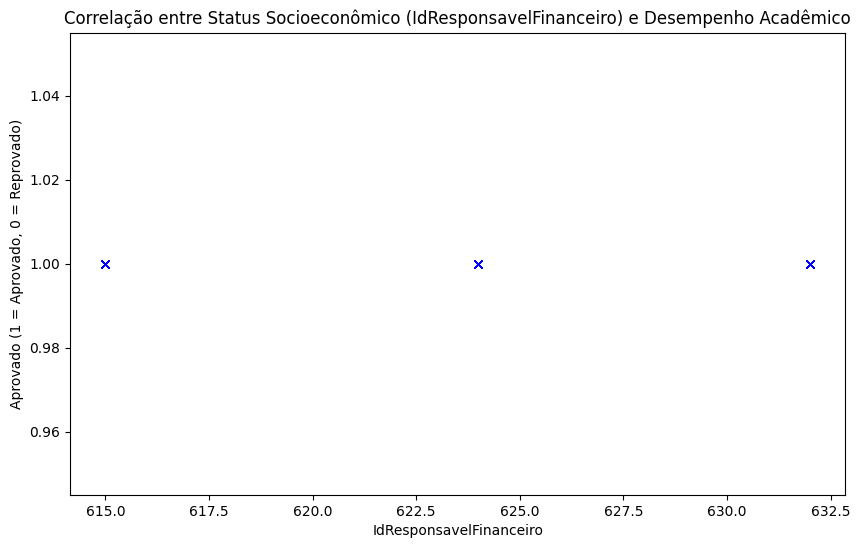

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gerar um gráfico de dispersão para visualizar a relação entre IdResponsavelFinanceiro e Aprovado
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IdResponsavelFinanceiro', y='Aprovado', data=df_filtered_socio, marker='x', color='blue')
plt.title('Correlação entre Status Socioeconômico (IdResponsavelFinanceiro) e Desempenho Acadêmico')
plt.xlabel('IdResponsavelFinanceiro')
plt.ylabel('Aprovado (1 = Aprovado, 0 = Reprovado)')
plt.show()

## 4.3 Análise de Engajamento e Faltas

c:\Users\Elitebook\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


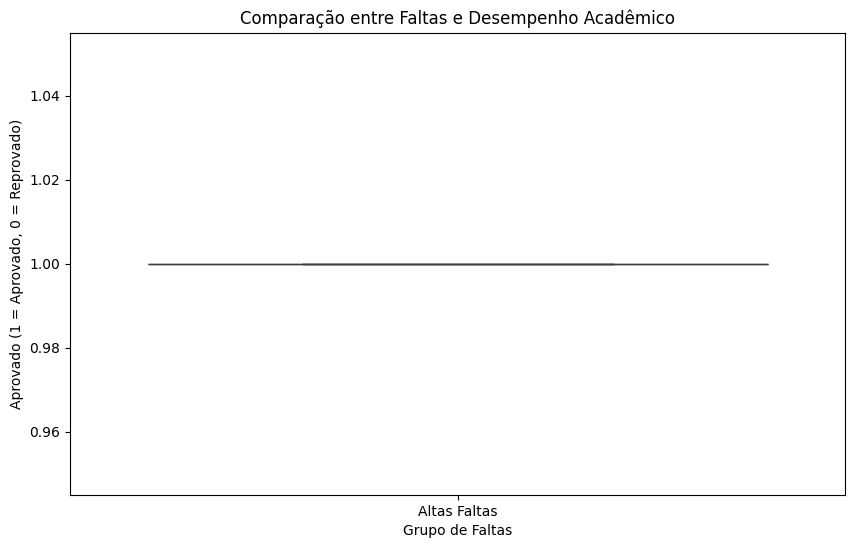

Mediana de Faltas: 0.0


In [37]:
# Filtrar os dados para incluir registros com dados completos para QuantidadeFaltasAnual e ResultadoFinal_x
df_filtered_faltas = df_filtered.dropna(subset=['QuantidadeFaltasAnual', 'ResultadoFinal_x'])

# Converter a coluna de resultado final para uma variável binária (Aprovado = 1, Reprovado = 0)
df_filtered_faltas['Aprovado'] = df_filtered_faltas['ResultadoFinal_x'].apply(lambda x: 1 if x == 'A' else 0)

# Criar um grupo de alunos com baixas faltas (menor que a mediana) e altas faltas (maior ou igual à mediana)
mediana_faltas = df_filtered_faltas['QuantidadeFaltasAnual'].median()
df_filtered_faltas['GrupoFaltas'] = df_filtered_faltas['QuantidadeFaltasAnual'].apply(lambda x: 'Baixas Faltas' if x < mediana_faltas else 'Altas Faltas')

# Comparar o desempenho entre grupos de baixas e altas faltas
plt.figure(figsize=(10, 6))
sns.boxplot(x='GrupoFaltas', y='Aprovado', data=df_filtered_faltas)
plt.title('Comparação entre Faltas e Desempenho Acadêmico')
plt.xlabel('Grupo de Faltas')
plt.ylabel('Aprovado (1 = Aprovado, 0 = Reprovado)')
plt.show()

# Exibir a mediana das faltas para referência
print(f"Mediana de Faltas: {mediana_faltas}")


c:\Users\Elitebook\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


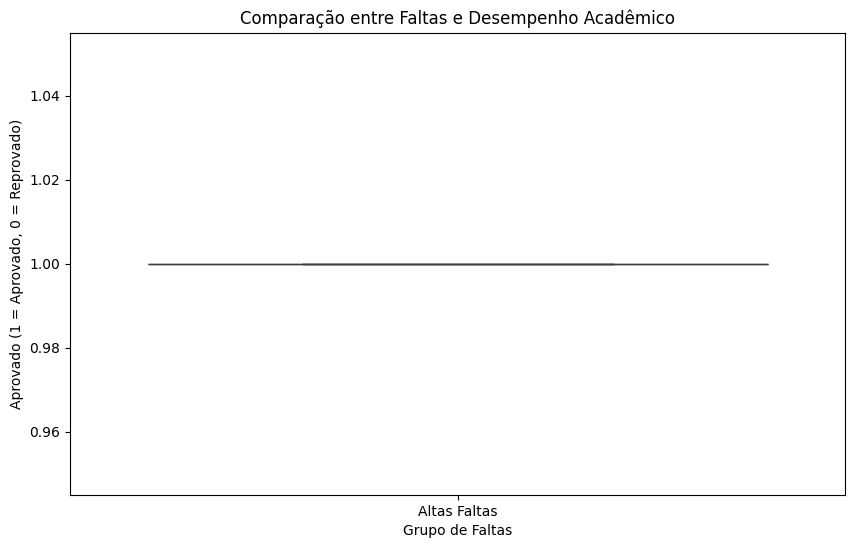

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de comparação entre grupos de baixas e altas faltas no desempenho
plt.figure(figsize=(10, 6))
sns.boxplot(x='GrupoFaltas', y='Aprovado', data=df_filtered_faltas)
plt.title('Comparação entre Faltas e Desempenho Acadêmico')
plt.xlabel('Grupo de Faltas')
plt.ylabel('Aprovado (1 = Aprovado, 0 = Reprovado)')
plt.show()

## 4.4 Evolução Temporal do Desempenho

AnoConclusao_y
2021.0    1.0
Name: Aprovado, dtype: float64


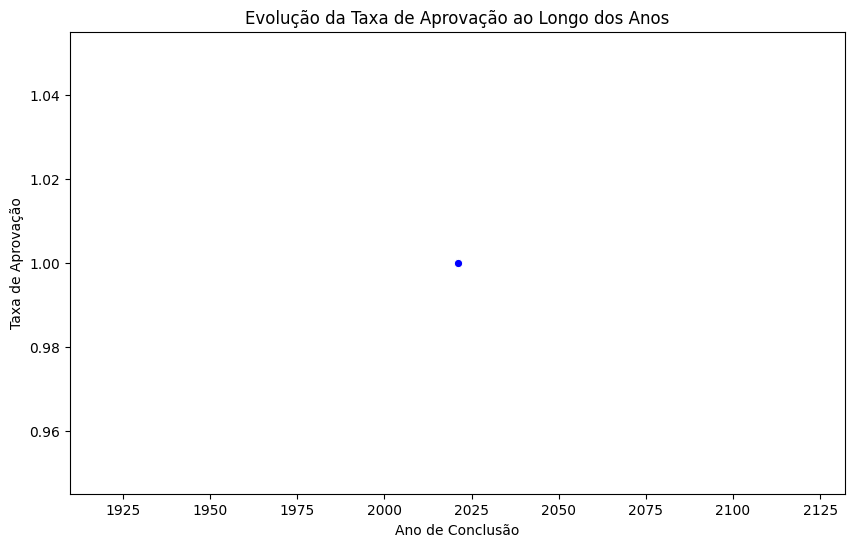

In [39]:
# Filtrar os dados para incluir registros com dados completos para ResultadoFinal_x e AnoConclusao_y
df_filtered_ano = df_filtered.dropna(subset=['AnoConclusao_y', 'ResultadoFinal_x'])

# Converter a coluna de resultado final para uma variável binária (Aprovado = 1, Reprovado = 0)
df_filtered_ano['Aprovado'] = df_filtered_ano['ResultadoFinal_x'].apply(lambda x: 1 if x == 'A' else 0)

# Agrupar os dados por ano de conclusão e calcular a taxa de aprovação
taxa_aprovacao_por_ano = df_filtered_ano.groupby('AnoConclusao_y')['Aprovado'].mean()

# Exibir as taxas de aprovação por ano
print(taxa_aprovacao_por_ano)

# Gerar um gráfico de linha para mostrar a evolução da taxa de aprovação ao longo dos anos
plt.figure(figsize=(10, 6))
sns.lineplot(x=taxa_aprovacao_por_ano.index, y=taxa_aprovacao_por_ano.values, marker='o', color='blue')
plt.title('Evolução da Taxa de Aprovação ao Longo dos Anos')
plt.xlabel('Ano de Conclusão')
plt.ylabel('Taxa de Aprovação')
plt.show()

## 4.5 Perfil dos Alunos Assistidos pela ONG

            IdAluno  IdResponsavelFinanceiro  QuantidadeFaltasAnual
count  49089.000000             49089.000000                16375.0
mean     855.121860               717.014219                    0.0
std      178.101829               140.526398                    0.0
min      727.000000               615.000000                    0.0
25%      727.000000               615.000000                    0.0
50%      773.000000               655.000000                    0.0
75%     1147.000000               938.000000                    0.0
max     1310.000000              1199.000000                    0.0


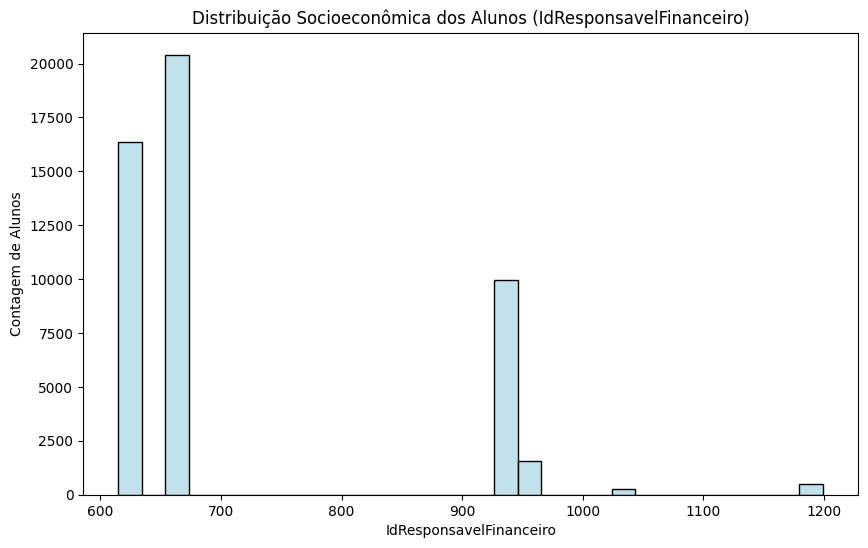

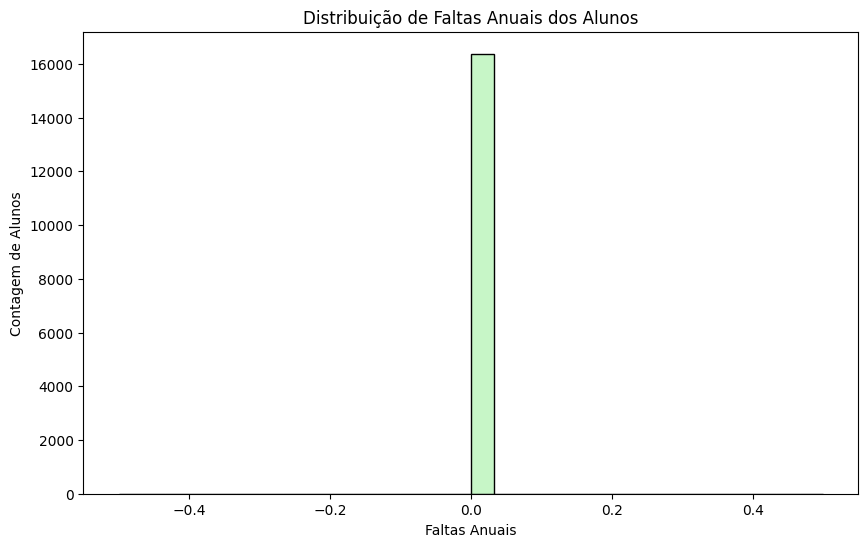

In [40]:
# Gerar estatísticas descritivas básicas para o perfil dos alunos assistidos pela ONG
perfil_alunos = df_merged[['IdAluno', 'IdResponsavelFinanceiro', 'QuantidadeFaltasAnual']].describe()

# Exibir estatísticas descritivas do perfil dos alunos
print(perfil_alunos)

# Verificar a distribuição dos alunos por IdResponsavelFinanceiro (indicador socioeconômico)
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['IdResponsavelFinanceiro'].dropna(), bins=30, kde=False, color='lightblue')
plt.title('Distribuição Socioeconômica dos Alunos (IdResponsavelFinanceiro)')
plt.xlabel('IdResponsavelFinanceiro')
plt.ylabel('Contagem de Alunos')
plt.show()

# Verificar a distribuição de faltas
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['QuantidadeFaltasAnual'].dropna(), bins=30, kde=True, color='lightgreen')
plt.title('Distribuição de Faltas Anuais dos Alunos')
plt.xlabel('Faltas Anuais')
plt.ylabel('Contagem de Alunos')
plt.show()
